In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
from numpy import ma
import pycircstat
from statsmodels.stats.multitest import multipletests as mt

cmap = plt.cm.Spectral
%matplotlib inline

### Define some custom functions/classes

In [120]:
class Point:
    def __init__(self, coord=None):
        self.coord = np.array(coord)
        
class LineSegment:  
    def __init__(self, p1=None, p2=None):
        if isinstance(p1, Point):
            self.p1 = p1
        else:
            self.p1 = Point(p1)
            
        if isinstance(p2, Point):
            self.p2 = p2
        else:
            self.p2 = Point(p2)
        
    def intersect(self, z):
        if isinstance(z, Circle):
            return _seg_intersect_circle(self, z)
        elif isinstance(x, Rectangle):
            return _seg_intersect_rect(self, z)
        
    def norm(self):
        diff = self.p2.coord-self.p1.coord
        return diff/np.linalg.norm(diff)
    
    def get_p1(self):
        return self.p1.coord
    
    def get_p2(self):
        return self.p2.coord
    
    def get_vec(self):
        return self.p2.coord-self.p1.coord
        
    def angle(self, ref=None):
        if ref==None:
            p1 = np.zeros_like(self.get_p1())
            p2 = np.zeros_like(self.get_p1())
            p2[0] = 1
            ref = LineSegment(p1, p2)
        v0 = ref.get_vec()
        v1 = self.get_vec()
        return np.arccos(v0.dot(v1)/(np.linalg.norm(v0)*np.linalg.norm(v1)))
        
class Circle:
    def __init__(self, center=None, r=None):
        self.center = np.array(center)
        self.r = r 
    
    def get_center(self):
        return self.center
    
    def get_radius(self):
        return self.r
        
class Rectangle:
    def __init__(self, x=None, y=None, w=None):
        self.c0 = x-w
        self.c1 = y-w
        self.c2 = x+w
        self.c3 = y+w
    
def _seg_intersect_circle(ls, circ):
     
    Q = circ.get_center()
    r = circ.get_radius()
    P1 = ls.get_p1()
    V = ls.get_p2() - P1
    
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r**2
    
    disc = b**2 - 4 * a * c
    if disc < 0:
        return False
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False
    
    return True
    
def _seg_intersect_rect(ls, r):
    
    # find min/max X for the segment
    minX = min(ls.p1.x, ls.p2.x)
    maxX = max(ls.p1.x, ls.p2.x)
    
    # find the intersection of the segment's and rectangle's x-projections
    if maxX > r.c2:
        maxX = r.c2
    if minX < r.c0:
        minX = r.c0
    
    if minX > maxX:
        return False
    
    minY = ls.p1.y
    maxY = ls.p2.y
    
    dx = ls.p2.x - ls.p1.x
    
    if abs(dx) > .0000001:
        a = (ls.p2.y - ls.p1.y) / dx
        b = ls.p1.y - a * ls.p1.x
        minY = a * minX + b
        maxY = a * maxX + b
        
    if minY > maxY:
        tmp = maxY
        maxY = minY
        minY = tmp
        
    # find the intersection of the segment's and rectangle's y-projections
    if maxY > r.c3:
        maxY = r.c3
    if minY < r.c1:
        minY = r.c1
        
    # if Y-projections do not intersect return false
    if minY > maxY:
        return False
    else:
        return True
    
def add_arrows(axes, x, y, **kwargs):

    # spacing of arrows
    aspace = .05 # good value for scale of 1
    aspace *= scale

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = 0 # current point on walk along data
    rcount = 1 
    while arrowPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit
        axes.arrow(ax,ay,
                   np.sin(theta)*aspace/10,np.cos(theta)*aspace/10, 
                   head_width=aspace/3, **kwargs)

### Set path

In [121]:
datadir = '../../../data/processed/'

### Load the data

In [122]:
embeddings = np.load(datadir+'embeddings_wasserstein2.npy')
video_embedding = embeddings[-2]
recall_embeddings = embeddings[:-2]
avg_recall_embedding = embeddings[-1]
mappings = np.load(datadir+'labels_wasserstein2.npy')

### Create a 2D grid

In [123]:
step = .25
scale = 6
X, Y = np.meshgrid(np.arange(-scale, scale, step), np.arange(-scale, scale, step))

In [124]:
video_embedding = video_embedding - video_embedding.mean(0)
recall_embeddings = list(map(lambda x: np.array(x) - np.vstack(recall_embeddings[0]).mean(0), recall_embeddings[0]))

### Turn the embedded recall event models into a list of line segments

In [125]:
seglist = []
for sub in recall_embeddings:
    for i in range(sub.shape[0]-1):
#         p1 = Point(x=sub[i, 0], y=sub[i, 1])
#         p2 = Point(x=sub[i+1, 0], y=sub[i+1, 1])
        p1 = Point(coord=sub[i, :])
        p2 = Point(coord=sub[i+1, :])
        seg = LineSegment(p1=p1, p2=p2)
        seglist.append(seg)

In [126]:
avg_recall = avg_recall_embedding - avg_recall_embedding.mean(0)

## Compute the average vector and p value at each grid point

In [127]:
def compute_coord(xi, yi, w, seglist, kind='rectangle'):
    
    if kind=='rectangle':
        z = Rectangle(x=xi, y=yi, w=w)
    elif kind=='circle':
        z = Circle(center=[xi,yi], r=w)
        
    segs = list(filter(lambda s: s.intersect(z), seglist))
    
    if len(segs)>1:
        u, v  = np.array([seg.norm() for seg in segs]).mean(0)
        rads = np.array([seg.angle() for seg in segs])
        p, z = pycircstat.tests.rayleigh(rads)
    else:
        u = 0
        v = 0
        p = 1
    c = len(segs)
    return u, v, p, c

U = np.zeros_like(X)
V = np.zeros_like(X)
P = np.zeros_like(X)
Z = np.zeros_like(X)
C = np.zeros_like(X)
for i, (x, y) in enumerate(zip(X, Y)):
    for j, (xi, yi) in enumerate(zip(x, y)):
        U[i, j], V[i, j], P[i, j], C[i, j] = compute_coord(xi, yi, step, seglist, kind='circle')

## Multiple comparisons correction

In [128]:
thresh = .05
Pc = mt(P.ravel(), method='fdr_bh', alpha=.05)[1].reshape(*P.shape)
Pc = P.copy()
X_sig = X[Pc<thresh]
X_notsig = X[Pc>thresh]
Y_sig = Y[Pc<thresh]
Y_notsig = Y[Pc>thresh]
U_sig = U[Pc<thresh]
U_notsig = U[Pc>thresh]
V_sig = V[Pc<thresh]
V_notsig = V[Pc>thresh]
M = np.hypot(U, V)
M = plt.cm.Blues(M)
M[Pc>thresh]=[.5, .5, .5, .25]
M[P==1]=[.5, .5, .5, 0]

### Plot the result

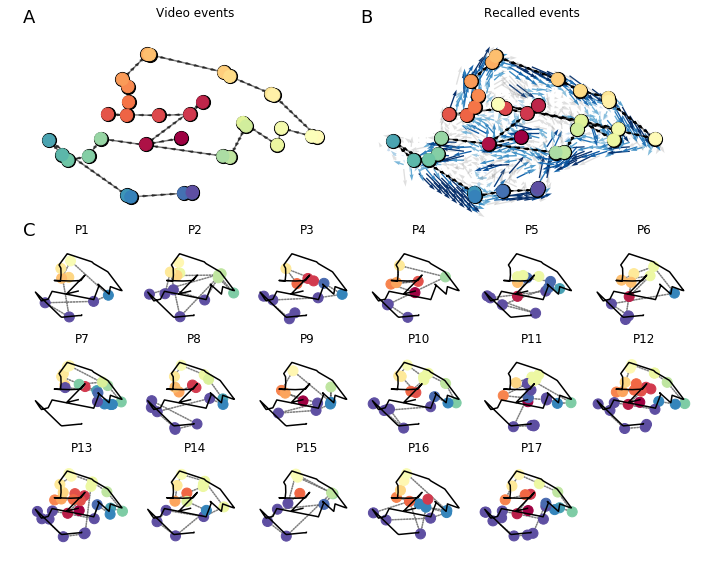

In [129]:
plt.figure(figsize=(10,8))
mpl.rcParams['pdf.fonttype'] = 42
axarr = [0 for i in range(2)]
axarr[0] = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=2)
axarr[1] = plt.subplot2grid((5, 6), (0, 3), colspan=3, rowspan=2)
color_range = range(video_embedding.shape[0])
for i in range(2, 5):
    for j in range(0, 6):
        ax = plt.subplot2grid((5, 6), (i, j))
        axarr.append(ax)

# # fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c=color_range, cmap=cmap, s=150, zorder=3)
axarr[0].scatter(video_embedding[:, 0], video_embedding[:, 1], c='k', cmap=cmap, s=200, zorder=2)
axarr[0].plot(video_embedding[:, 0], video_embedding[:, 1], zorder=1, c='k', alpha=.5)
add_arrows(axarr[0], video_embedding[:, 0], video_embedding[:, 1], zorder=0, alpha=.5, color='k', fill=True)
axarr[0].axis('off')
axarr[0].set_title('Video events')
axarr[0].set_xlim(-5, 6)
axarr[0].set_ylim(-5, 6)
axarr[0].text(0, 1,'A',
        horizontalalignment='center',
        transform=axarr[0].transAxes,
          fontsize=18)

axarr[1].quiver(X, Y, U, V, color=M.reshape(M.shape[0]*M.shape[1],4), zorder=1, width=.004)
axarr[1].plot(avg_recall[:, 0], avg_recall[:, 1], zorder=2, c='k', alpha=.5)
add_arrows(axarr[1], avg_recall[:, 0], avg_recall[:, 1], zorder=3, alpha=1, color='k', fill=True)
axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c=color_range, cmap=cmap, s=150, zorder=4)
axarr[1].scatter(avg_recall[:, 0], avg_recall[:, 1], c='k', cmap=cmap, s=200, zorder=3)
axarr[1].axis('off')
axarr[1].set_title('Recalled events')
axarr[1].set_xlim(-5, 6)
axarr[1].set_ylim(-5, 6)
axarr[1].text(0, 1,'B',
        horizontalalignment='center',
        transform=axarr[1].transAxes,
          fontsize=18)
axarr[2].text(0, 1.05,'C',
        horizontalalignment='center',
        transform=axarr[2].transAxes,
          fontsize=18)

for i, (e, m) in enumerate(zip(recall_embeddings, mappings)):
    axarr[i+2].scatter(e[:,0], e[:,1], c=cmap(m/21), cmap=cmap, s=100, zorder=2)
    axarr[i+2].plot(e[:,0], e[:,1], zorder=1, c='k', alpha=.25)
    add_arrows(axarr[i+2], e[:,0], e[:,1], zorder=1, alpha=.25, color='k', fill=True)
    axarr[i+2].plot(video_embedding[:, 0], video_embedding[:, 1], c='k', zorder=3)
    axarr[i+2].axis('off')
    axarr[i+2].set_xlim(-5, 6)
    axarr[i+2].set_ylim(-5, 6)
    axarr[i+2].set_title('P%s' % str(i+1))
axarr[i+3].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=.05, hspace=.25)
# plt.savefig('../../../paper/figs/trajectory_wasserstein.pdf')
plt.savefig('/mnt/trajectory_wasserstein.pdf')
plt.show()